In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import plotly.express as px
import plotly.graph_objects as go

import datetime as dt

In [3]:
stores = pd.read_csv('../data/clean_data/profits_clean.csv', compression='zip', parse_dates=True)
stores.head(2)

,ar_div,customer_num,sold_to_name,product_line,year,month,start_date,end_date,quantity,ext_price,ext_cost,gross_profit,territory,date
0,0,1000438,Farmer Joe's - Fruitvale Ave.,DCD,2017,1,1/1/2017,12/31/2017,1941.0,6976.1,4969.73,2006.37,EB,2017-01-01
1,0,1014136,"Seven Eleven-Redwood Hwy,M.V.",DCD,2017,1,1/1/2017,12/31/2017,120.0,186.0,148.08,37.92,MR,2017-01-01


In [4]:
# filter for columns that will be used
cols = [
    'sold_to_name',
    'product_line',
    'date',
    'gross_profit'
]

# filter data to use the columns above
stores = stores[cols]
stores.head(2)

,sold_to_name,product_line,date,gross_profit
0,Farmer Joe's - Fruitvale Ave.,DCD,2017-01-01,2006.37
1,"Seven Eleven-Redwood Hwy,M.V.",DCD,2017-01-01,37.92


In [5]:
stores['product_line'].value_counts()

DCD    19570
PF      7987
Name: product_line, dtype: int64

In [6]:
# remove pepperidge rows
stores = stores[stores['product_line'].isin(['PFBI', 'PFCR']) == False]
stores.drop(columns='product_line', inplace=True)
stores.head(2)

,sold_to_name,date,gross_profit
0,Farmer Joe's - Fruitvale Ave.,2017-01-01,2006.37
1,"Seven Eleven-Redwood Hwy,M.V.",2017-01-01,37.92


# RFM Segmentation

R = Recency

F = Frequency

M = Monetary

In this section I will create and assign values (1-4) for each stores based on recent purchases, frequency of purchases, and how much money was spent

I followed this blog post on how to use RFM.

Some code was taken from here and transformed to fit my project.

https://medium.com/web-mining-is688-spring-2021/using-k-means-to-segment-customers-based-on-rfm-variables-9d4d683688c8

In [7]:
# group by store and date, sum the profits
# this was needed because there were multiple entries for stores and dates for different product lines
stores = stores.groupby(by=['sold_to_name', 'date'], as_index=False).sum()
stores.head(2)

,sold_to_name,date,gross_profit
0,17th & Balboa Market,2017-02-01,74.87
1,17th & Cole Market,2017-01-01,82.06


In [8]:
# the last date in the dataset (used for frequency)
last_date = max(stores['date']).split('-')                          # max date in the dataset, split on '-'
last_date = list(map(int, last_date))                               # convert numbers in date from string to int
last_date = dt.date(last_date[0], last_date[1], last_date[2])       # convert to datetime

stores['date'] = pd.DatetimeIndex(stores['date']).date

## Recency

In [9]:
# groupby stores and get the max date (most recent)
stores_recency = stores.groupby(['sold_to_name'], as_index=False)['date'].max()
stores_recency.columns = ['sold_to_name', 'last_purchase_date']

# create recency column
# subtract the last purchase date from the last date in the dataset
# this gives you the days since last purchase. Divide by 30 to convert to months
stores_recency['recency'] = stores_recency['last_purchase_date'].apply(lambda x: ((last_date - x).days)/30)

stores_recency.head(2)

,sold_to_name,last_purchase_date,recency
0,17th & Balboa Market,2017-02-01,58.8
1,17th & Cole Market,2021-07-01,5.1


## Frequency and Monetary

In [10]:
# group by store
fm_table = stores.groupby(['sold_to_name']).agg(
    {'sold_to_name': lambda x: len(x),                  # get the length of the how many time the store name shows up (frequency)
    'gross_profit': lambda x: sum(x)}                   # the sum of all profits (monetary)
)

# rename columns
fm_table.rename(columns={'sold_to_name': 'frequency', 'gross_profit': 'monetary'}, inplace=True)

fm_table.head(2)

,frequency,monetary
sold_to_name,,
17th & Balboa Market,1,74.87
17th & Cole Market,44,2997.60


In [11]:
# combine recency with frequency and monetary
rfm_table = stores_recency.merge(fm_table, left_on='sold_to_name', right_on='sold_to_name')
rfm_table.drop(columns='last_purchase_date', inplace=True)

rfm_table.head()

,sold_to_name,recency,frequency,monetary
0,17th & Balboa Market,58.8,1,74.87
1,17th & Cole Market,5.1,44,2997.60
2,25th & Clement Produce,0.0,58,12919.35
3,300 Church St. Market,0.0,60,13191.46
4,3rd Ave Food Market,53.8,5,753.99


In [12]:
# get the quantiles for recency, frequency, and monetary
quantiles = rfm_table.quantile(q=[0.25, 0.50, 0.75])
quantiles = quantiles.to_dict()

In [13]:
# this function calculates the recency scores
# assigns values 1-4 based on what quartile the scores fall in
def r_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# this function calculates the frequency and monetary scores
# assigns values 1-4 based on what quartile the scores fall in
def fm_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [14]:
# create a copy of the table to add quartiles
segmented_rfm = rfm_table.copy()

# create quartile columns for recency, frequency, and monetary
# apply the functions to each score to get the value
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(r_score, args=('recency', quantiles))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(fm_score, args=('frequency', quantiles))
segmented_rfm['m_quartile'] = segmented_rfm['monetary'].apply(fm_score, args=('monetary', quantiles))

segmented_rfm.head(2)

,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
0,17th & Balboa Market,58.8,1,74.87,4,4,4
1,17th & Cole Market,5.1,44,2997.60,3,2,3


In [15]:
# convert the values from each quartile into strings and concatenate
segmented_rfm['rfm_segment'] = segmented_rfm['r_quartile'].map(str) + segmented_rfm['f_quartile'].map(str) + segmented_rfm['m_quartile'].map(str)

# get the sum of recency, frequency, and monetary values
segmented_rfm['rfm_score'] = segmented_rfm[['r_quartile', 'f_quartile', 'm_quartile']].sum(axis=1)

segmented_rfm.head()

,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score
0,17th & Balboa Market,58.8,1,74.87,4,4,4,444,12
1,17th & Cole Market,5.1,44,2997.60,3,2,3,323,8
2,25th & Clement Produce,0.0,58,12919.35,1,2,2,122,5
3,300 Church St. Market,0.0,60,13191.46,1,2,2,122,5
4,3rd Ave Food Market,53.8,5,753.99,4,4,3,443,11


# K-means

In this section I will use K-means to cluster the stores based on the RFM segmentation.

In [16]:
# create a copy of the table and log the monetary column
# this creates a normal distribution which will give better results when using K-means
rfm_table_log = rfm_table.copy()
rfm_table_log['monetary'] = np.log(rfm_table_log['monetary'])

rfm_table_log.head(2)

,sold_to_name,recency,frequency,monetary
0,17th & Balboa Market,58.8,1,4.315753
1,17th & Cole Market,5.1,44,8.005567


In [17]:
# create a dataframe with just the scores
rfm_scores = rfm_table_log.drop(columns='sold_to_name')

In [18]:
# instantiate StandardScaler, fit and transform rfm_scores
sc = StandardScaler()
rfm_scores_scaled = sc.fit_transform(rfm_scores)

In [19]:
# create an inertia list to find the optimal number of clusters
inertia_list = []

for k in range(1,51):
    kmeans = KMeans(n_clusters=k, max_iter=10_000, random_state=12)
    kmeans.fit(rfm_scores_scaled)
    inertia_list.append(kmeans.inertia_)

inertia_list[:2]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


[1197.0000000000002, 326.7400405788324]

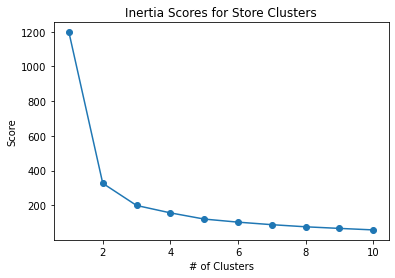

In [20]:
plt.plot(range(1,11), inertia_list[:10], marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Inertia Scores for Store Clusters');

# used the elbow method to find the optimal amount of clusters
# from this plot, the best amount of clusters seem to be 3 or 4

In [21]:
# create a silhouette list to find the optimal amount of clusters
silhouette_list = []

for k in range(2,51):
    kmeans = KMeans(n_clusters=k, random_state=12)
    kmeans.fit(rfm_scores_scaled)
    silhouette_list.append(silhouette_score(rfm_scores_scaled, kmeans.labels_))

silhouette_list[:2]

[0.6264957792299395, 0.5536192278697717]

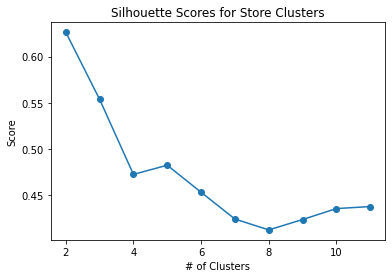

In [22]:
plt.plot(range(2,12), silhouette_list[:10], marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores for Store Clusters');

# used the elbow method to find the optimal amount of clusters
# from this plot, the best amount of clusters seem to be 3

3 or 4 clusters seem to be the best. I will now test both.

In [23]:
kmeans3 = KMeans(n_clusters=3, max_iter=10_000, random_state=12)
kmeans3.fit(rfm_scores_scaled)

KMeans(max_iter=10000, n_clusters=3, random_state=12)

In [24]:
kmeans4 = KMeans(n_clusters=4, max_iter=10_000, random_state=12)
kmeans4.fit(rfm_scores_scaled)

KMeans(max_iter=10000, n_clusters=4, random_state=12)

In [25]:
rfm_table_log['labels3'] = kmeans3.labels_
rfm_table_log['labels4'] = kmeans4.labels_

In [26]:
segmented_rfm['labels3'] = kmeans3.labels_
segmented_rfm.head()

,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3
0,17th & Balboa Market,58.8,1,74.87,4,4,4,444,12,2
1,17th & Cole Market,5.1,44,2997.60,3,2,3,323,8,0
2,25th & Clement Produce,0.0,58,12919.35,1,2,2,122,5,0
3,300 Church St. Market,0.0,60,13191.46,1,2,2,122,5,0
4,3rd Ave Food Market,53.8,5,753.99,4,4,3,443,11,2


In [27]:
segmented_rfm.to_csv('../data/clean_data/stores_segmented.csv', compression='zip', index=False)

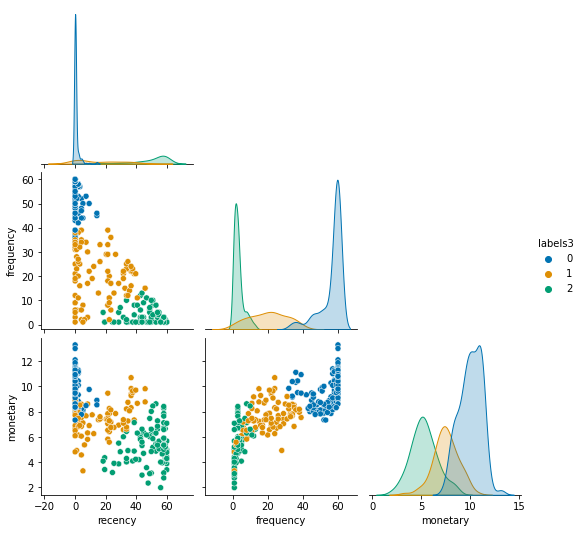

In [28]:
sns.pairplot(
    rfm_table_log.drop(columns=['labels4']), 
    hue='labels3', 
    corner=True, 
    palette='colorblind'
);

Three clusters seems to separate the data very well. I'll try 4 next and compare.

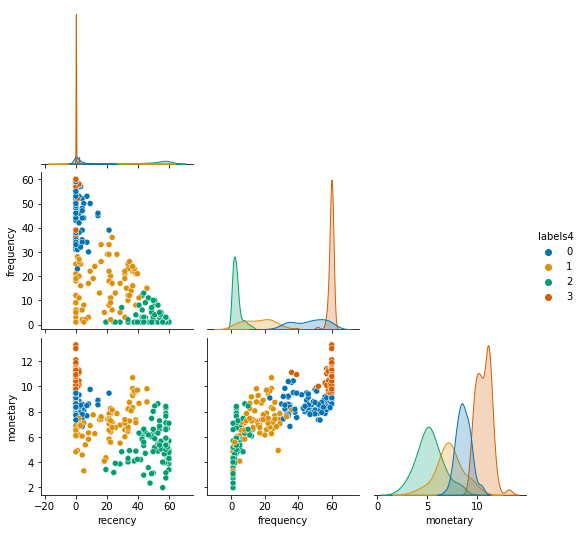

In [29]:
sns.pairplot(
    rfm_table_log.drop(columns=['labels3']), 
    hue='labels4', 
    corner=True, 
    palette='colorblind'
);

4 clusters split the data fairly well. I will plot in 3d to try and get a better idea of what's going on.

In [30]:
rfm_table_log['labels3'] = rfm_table_log['labels3'].map({0: 'Best Stores', 1: 'Average Stores', 2: 'Worst Stores'})

In [49]:
x_eye = -1.25
y_eye = 2
z_eye = 0.5

fig = px.scatter_3d(
    rfm_table_log.drop(columns=['labels4']), 
    x='recency', 
    y='frequency', 
    z='monetary', 
    color='labels3',
    title='Clusters of Stores',
    width=1200,
    height=800
)

fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    legend=dict(font=dict(size= 20)),
    legend_title_text='Store Cluster',
    title_font_size=24
)

fig.update_layout(scene = dict(
                    xaxis_title='Recency',
                    yaxis_title='Frequency',
                    zaxis_title='Monetary'),
                    font=dict(size= 14),
                    # width=700,
                    margin=dict(r=20, b=10, l=10, t=10))



# code for animated rotation
# taken from 
# https://github.com/Coding-with-Adam/Dash-by-Plotly/blob/master/Plotly_Graphs/3d_scatter/scatter3d.py
fig.update_layout(scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
                  updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                  method='animate',
                                                  args=[None, dict(frame=dict(duration=250, redraw=True),
                                                                   transition=dict(duration=0),
                                                                   fromcurrent=True,
                                                                   mode='immediate'
                                                                   )]
                                                  )
                                             ]
                                    )
                               ]
                  )


def rotate_z(x, y, z, theta):
    w = x + 1j * y
    return np.real(np.exp(1j * theta) * w), np.imag(np.exp(1j * theta) * w), z


frames = []

for t in np.arange(0, 6.26, 0.1):
    xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
    frames.append(go.Frame(layout=dict(scene_camera_eye=dict(x=xe, y=ye, z=ze))))
fig.frames = frames


fig.write_html("My3dPlot.html")

fig.show()

3 clusters splits the data very well. There seem to be no major outliers.

In [32]:
px.scatter_3d(
    rfm_table_log.drop(columns=['labels3']), 
    x='recency', 
    y='frequency', 
    z='monetary', 
    color='labels4'
)